In [1]:
# importing libs

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re ,string
import os
import nltk
from nltk.tag import pos_tag
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import *
from sklearn.metrics import *
import emoji
import regex
import xgboost
from xgboost import XGBClassifier
import spacy
import keras
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# installing nltk packages

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GABRIEL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GABRIEL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\GABRIEL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\GABRIEL\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GABRIEL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# folders

train_dataset = 'E:\\Projects\\tweets_disaster_classifier\\train.csv'
test_dataset = 'E:\\Projects\\tweets_disaster_classifier\\test.csv'
submit = 'E:\\Projects\\tweets_disaster_classifier\\sample_submission.csv'

In [4]:
# load datasets

df_train = pd.read_csv(train_dataset , sep =',')
df_test = pd.read_csv(test_dataset , sep =',')
df_sample = pd.read_csv(submit , sep =',')

In [5]:
df_train.shape

(7613, 5)

In [6]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
df_train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
harm                     41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [9]:
df_train['location'].value_counts()

USA                               104
New York                           71
United States                      50
London                             45
Canada                             29
                                 ... 
Uruguay / Westeros / Gallifrey      1
Alameda and Pleasanton, CA          1
USA/SO FLORIDA via BROOKLYN NY      1
The Sanctuary Network, Rome         1
Nicoma Park, OK                     1
Name: location, Length: 3341, dtype: int64

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [11]:
# replace nan values by '0'

df_train['keyword'] = df_train['keyword'].replace(np.nan, '0')
df_train['location'] = df_train['location'].replace(np.nan, '0')

df_test['keyword'] = df_test['keyword'].replace(np.nan, '0')
df_test['location'] = df_test['location'].replace(np.nan, '0')

Text(0.5, 1.0, 'Target Count')

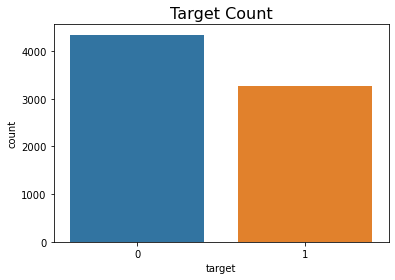

In [19]:
# plotting value counts of Rating (balaced dataset)

sns.countplot(x='target', data= df_train)
plt.title('Target Count', size = 16)

In [12]:
# trasforming text in new informations

df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_train['text_s'] = df_train['text'].apply(lambda x: x.split())
df_train['text_s'] = df_train['text_s'].apply(lambda x:[item.replace(',','') for item in x if item.count(',')!=-1])
df_train['words_number'] = df_train['text_s'].apply(lambda x: len(x))

df_test['text'] = df_test['text'].apply(lambda x: x.lower())
df_test['text_s'] = df_test['text'].apply(lambda x: x.split())
df_test['text_s'] = df_test['text_s'].apply(lambda x:[item.replace(',','') for item in x if item.count(',')!=-1])
df_test['words_number'] = df_test['text_s'].apply(lambda x: len(x))

In [69]:
diswords = ['dead','rain','hurricane','tornado',
             'deaths','emergency','fire','wind',
             'water','sea','break','crash',
            'street','police','murder','ambulance',
             'flame','shoot','kill','smoke','killed',
            'smoking','broke','breaking','flames',
            'murderer','polices','death','flood',
            'flooding','rainfall','rescue','train',
            'degrees','disaster','suicide','bomb',
            'bomber','wildfire','fatal','risk',
            'disasters','storm','shooting','accident',
            'explosion','cyclone','accidents','collision',
            'landslides','earthquake','lightening',
            'avalanche','cold','snow','trains','hospital',
            'gas','floods','outbreak','hurricane',
            'landslide','flash','shipwreck','typhoon']

In [70]:
def dis_words(x):
    a = 0
    for i in range(0, len(diswords),1):
        if x.find(diswords[i]) != -1:
            a = a+1
        else:
            pass
    return a   

In [71]:
df_train['dis_words'] = df_train['text'].apply(dis_words)
df_test['dis_words'] = df_test['text'].apply(dis_words)

In [83]:
# using spacy to Named Entity Recognition

nlp = spacy.load('en_core_web_sm')
df_train['text_nlp'] = df_train['text'].apply(lambda x: nlp(x))
df_train['nlp_types'] = df_train['text_nlp'].apply(lambda x: [item.ent_type_ for item in x if item.ent_type_] )
df_train['mf_class'] = df_train['nlp_types'].apply(lambda x: max(set(x) , key = x.count) if len(x)!=0 else '0')
df_train['org_class'] = df_train['nlp_types'].apply(lambda x: x.count('ORG'))
df_train['gpe_class'] = df_train['nlp_types'].apply(lambda x: x.count('GPE'))
df_train['car_class'] = df_train['nlp_types'].apply(lambda x: x.count('CARDINAL'))
df_train['dat_class'] = df_train['nlp_types'].apply(lambda x: x.count('DATE'))
df_train['per_class'] = df_train['nlp_types'].apply(lambda x: x.count('PERSON'))
df_train['mon_class'] = df_train['nlp_types'].apply(lambda x: x.count('MONEY'))
df_train['loc_class'] = df_train['nlp_types'].apply(lambda x: x.count('LOC'))
df_train['tim_class'] = df_train['nlp_types'].apply(lambda x: x.count('TIME'))
df_train['pro_class'] = df_train['nlp_types'].apply(lambda x: x.count('PRODUCT'))
df_train['nor_class'] = df_train['nlp_types'].apply(lambda x: x.count('NORP'))
df_train['qtd_class'] = df_train['nlp_types'].apply(lambda x: x.count('QUANTITY'))
df_train['fac_class'] = df_train['nlp_types'].apply(lambda x: x.count('FAC'))
df_train['nlp_types_syn'] = df_train['text_nlp'].apply(lambda x: [item.dep_ for item in x if item.dep_] )
df_train['sp_class'] = df_train['nlp_types_syn'].apply(lambda x: max(set(x) , key = x.count) if len(x)!=0 else '0')
df_train['pun_class'] = df_train['nlp_types_syn'].apply(lambda x: x.count('punct'))
df_train['com_class'] = df_train['nlp_types_syn'].apply(lambda x: x.count('compound'))
df_train['rot_class'] = df_train['nlp_types_syn'].apply(lambda x: x.count('ROOT'))
df_train['amd_class'] = df_train['nlp_types_syn'].apply(lambda x: x.count('amod'))
df_train['pre_class'] = df_train['nlp_types_syn'].apply(lambda x: x.count('prep'))
df_train['nsu_class'] = df_train['nlp_types_syn'].apply(lambda x: x.count('nsubj'))
df_train['dob_class'] = df_train['nlp_types_syn'].apply(lambda x: x.count('dobj'))
df_train['det_class'] = df_train['nlp_types_syn'].apply(lambda x: x.count('det'))
df_train['adv_class'] = df_train['nlp_types_syn'].apply(lambda x: x.count('advmod'))
df_train['pob_class'] = df_train['nlp_types_syn'].apply(lambda x: x.count('pobj'))

# test dataset

df_test['text_nlp'] = df_test['text'].apply(lambda x: nlp(x))
df_test['nlp_types'] = df_test['text_nlp'].apply(lambda x: [item.ent_type_ for item in x if item.ent_type_] )
df_test['mf_class']  = df_test['nlp_types'].apply(lambda x: max(set(x) , key = x.count) if len(x)!=0 else '0')
df_test['org_class'] = df_test['nlp_types'].apply(lambda x: x.count('ORG'))
df_test['gpe_class'] = df_test['nlp_types'].apply(lambda x: x.count('GPE'))
df_test['car_class'] = df_test['nlp_types'].apply(lambda x: x.count('CARDINAL'))
df_test['dat_class'] = df_test['nlp_types'].apply(lambda x: x.count('DATE'))
df_test['per_class'] = df_test['nlp_types'].apply(lambda x: x.count('PERSON'))
df_test['mon_class'] = df_test['nlp_types'].apply(lambda x: x.count('MONEY'))
df_test['loc_class'] = df_test['nlp_types'].apply(lambda x: x.count('LOC'))
df_test['tim_class'] = df_test['nlp_types'].apply(lambda x: x.count('TIME'))
df_test['pro_class'] = df_test['nlp_types'].apply(lambda x: x.count('PRODUCT'))
df_test['nor_class'] = df_test['nlp_types'].apply(lambda x: x.count('NORP'))
df_test['qtd_class'] = df_test['nlp_types'].apply(lambda x: x.count('QUANTITY'))
df_test['fac_class'] = df_test['nlp_types'].apply(lambda x: x.count('FAC'))
df_test['nlp_types_syn'] = df_test['text_nlp'].apply(lambda x: [item.dep_ for item in x if item.dep_] )
df_test['sp_class'] = df_test['nlp_types_syn'].apply(lambda x: max(set(x) , key = x.count) if len(x)!=0 else '0')
df_test['pun_class'] = df_test['nlp_types_syn'].apply(lambda x: x.count('punct'))
df_test['com_class'] = df_test['nlp_types_syn'].apply(lambda x: x.count('compound'))
df_test['rot_class'] = df_test['nlp_types_syn'].apply(lambda x: x.count('ROOT'))
df_test['amd_class'] = df_test['nlp_types_syn'].apply(lambda x: x.count('amod'))
df_test['pre_class'] = df_test['nlp_types_syn'].apply(lambda x: x.count('prep'))
df_test['nsu_class'] = df_test['nlp_types_syn'].apply(lambda x: x.count('nsubj'))
df_test['dob_class'] = df_test['nlp_types_syn'].apply(lambda x: x.count('dobj'))
df_test['det_class'] = df_test['nlp_types_syn'].apply(lambda x: x.count('det'))
df_test['adv_class'] = df_test['nlp_types_syn'].apply(lambda x: x.count('advmod'))
df_test['pob_class'] = df_test['nlp_types_syn'].apply(lambda x: x.count('pobj'))

In [17]:
df_train.loc[df_train['target'] == 1]['text']

0       our deeds are the reason of this #earthquake m...
1                  forest fire near la ronge sask. canada
2       all residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       just got sent this photo from ruby #alaska as ...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @thetawniest the out of control w...
7610    m1.94 [01:04 utc]?5km s of volcano hawaii. htt...
7611    police investigating after an e-bike collided ...
7612    the latest: more homes razed by northern calif...
Name: text, Length: 3271, dtype: object

In [18]:
# importing list of words: positive and negative

eas = os.path.join('E:\\Projects\\tweets_disaster_classifier\\words_list')
pos_words_file = os.path.join(eas, 'positive_words.txt')
neg_words_file = os.path.join(eas, 'negative_words.txt')

pos_words = []
neg_words = []

# reading .txt files
for pos_word in open(pos_words_file, 'r').readlines():
    pos_words.append(pos_word.replace('\n',''))

for neg_word in open(neg_words_file, 'r').readlines():
    neg_words.append(neg_word.replace('\n',''))

In [19]:
# counting positive words in text

df_train['positive'] = df_train['text_s'].apply(lambda x: len((set(x) & set(pos_words))))
df_test['positive'] = df_test['text_s'].apply(lambda x: len((set(x) & set(pos_words))))

# counting negative words in text

df_train['negative'] = df_train['text_s'].apply(lambda x: len((set(x) & set(neg_words))))
df_test['negative'] = df_test['text_s'].apply(lambda x: len((set(x) & set(neg_words))))

# value of neutral words

df_train['neutro'] = df_train['words_number'] - (df_train['positive'] + df_train['negative'])
df_test['neutro'] = df_test['words_number'] - (df_test['positive'] + df_test['negative'])

# percentage of positive words of tweet

df_train['positive%'] = df_train['positive'] / df_train['words_number']
df_test['positive%'] = df_test['positive'] / df_test['words_number']

# percentage of negative words of tweet

df_train['negative%'] = df_train['negative'] / df_train['words_number']
df_test['negative%'] = df_test['negative'] / df_test['words_number']

# difference between positive and negative words of tweet

df_train['delta'] = df_train['positive'] - df_train['negative']
df_test['delta'] = df_test['positive'] - df_test['negative']

# counting first positives words of tweet (0 to 3° word)

df_train['first_words_p'] = df_train['text_s'].apply(lambda x: len((set(x[0:3]) & set(pos_words))))
df_test['first_words_p'] = df_test['text_s'].apply(lambda x: len((set(x[0:3]) & set(pos_words))))

# counting first negatives words of tweet (0 to 3° word)

df_train['first_words_n'] = df_train['text_s'].apply(lambda x: len((set(x[0:3]) & set(neg_words))))
df_test['first_words_n'] = df_test['text_s'].apply(lambda x: len((set(x[0:3]) & set(neg_words))))

# using nltk pack to identify the gramatical class of word

df_train['tags'] = df_train['text_s'].apply(lambda x: pos_tag(x))
df_test['tags'] = df_test['text_s'].apply(lambda x: pos_tag(x))

In [20]:
# extracting and count emojis

df_train['emoji'] = df_train['text'].apply(lambda x:re.findall(r'(:[^:]*:)', emoji.demojize(x)))
df_train['emoji_n'] = df_train['emoji'].apply(lambda x: len(x))

df_test['emoji'] = df_test['text'].apply(lambda x:re.findall(r'(:[^:]*:)', emoji.demojize(x)))
df_test['emoji_n'] = df_test['emoji'].apply(lambda x: len(x))

In [21]:
# extracting and count smiles: =) and sad: =(

df_train['smile']  = df_train['text'].apply(lambda x: 0 if (x.find('=)') and x.find(';)'))== -1 else 1 )
df_train['sad']  = df_train['text'].apply(lambda x: 0 if x.find('=(')!= -1 else 1)

df_test['smile']  = df_test['text'].apply(lambda x: 0 if (x.find('=)') and x.find(';)')) == -1 else 1 )
df_test['sad']  = df_test['text'].apply(lambda x: 0 if x.find('=(')!= -1 else 1)

In [22]:
# counting values of gramatical class

def tag_type(tag):
    tag_list = []
    for i in range(0,len(tag),1):
        tagt = tag[i][1]
        tag_list.append(tagt[0:2])
    return tag_list

df_train['tag_type'] = df_train['tags'].apply(tag_type)
df_test['tag_type'] = df_test['tags'].apply(tag_type)

# creating a dict count words of each gramatical class

df_train['dict_tag'] = df_train['tag_type'].apply(lambda x :{y:x.count(y) for y in x})
df_test['dict_tag'] = df_test['tag_type'].apply(lambda x :{y:x.count(y) for y in x})

In [23]:
# building function to split gramatical classes in columns

def class_type(tag):
    try:
        adj = tag['JJ']
    except:
        adj = 0
    try:
        vb = tag['VB']
    except:
        vb = 0
    try:
        subs = tag['NN']
    except:
        subs = 0
    try:
        inj = tab['UH']
    except:
        inj = 0
    return pd.Series([adj , vb , subs , inj])

In [24]:
# counting in columns

df_train[['adj','vb','subs','inj']] = df_train['dict_tag'].apply(class_type)
df_test[['adj','vb','subs','inj']] = df_test['dict_tag'].apply(class_type)

In [25]:
# samples tweets from nltk package

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')
tweet_tokens_p = twitter_samples.tokenized('positive_tweets.json')
tweet_tokens_n = twitter_samples.tokenized('negative_tweets.json')

In [26]:
stop_words = stopwords.words('english')

In [27]:
# building functions to morphological analize and remove noise
# 1
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

#2
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [28]:
# apply the functions

tweet_tokens_p = list(map(lambda x: lemmatize_sentence(x), tweet_tokens_p))
tweet_tokens_n = list(map(lambda x: lemmatize_sentence(x), tweet_tokens_n))

tweet_tokens_p = list(map(lambda x: remove_noise(x), tweet_tokens_p))
tweet_tokens_n = list(map(lambda x: remove_noise(x), tweet_tokens_n))

In [29]:
# appending all the tweets

for i in range(1 , len(tweet_tokens_p),1):
    positive_tweets = tweet_tokens_p[0]
    positive_tweets.extend(tweet_tokens_p[i])

In [30]:
for i in range(1 , len(tweet_tokens_n),1):
    negative_tweets = tweet_tokens_n[0]
    negative_tweets.extend(tweet_tokens_n[i])

In [31]:
# counting positive words in text

df_train['pos_tweet'] = df_train['text_s'].apply(lambda x: len((set(x) & set(positive_tweets))))
df_test['pos_tweet'] = df_test['text_s'].apply(lambda x: len((set(x) & set(positive_tweets))))

# counting negative words in text

df_train['neg_tweet'] = df_train['text_s'].apply(lambda x: len((set(x) & set(negative_tweets))))
df_test['neg_tweet'] = df_test['text_s'].apply(lambda x: len((set(x) & set(negative_tweets))))

In [32]:
# difference between positive and negaative tweets

df_train['delta2'] = df_train['pos_tweet'] - df_train['neg_tweet']
df_test['delta2'] = df_test['pos_tweet'] - df_test['neg_tweet']

In [33]:
# functions to 
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_pos_words = get_all_words(tweet_tokens_p)
all_neg_words = get_all_words(tweet_tokens_n)

In [34]:
# verifing the frequency of words

freq_dist_pos = FreqDist(all_pos_words)
freq_dist_neg = FreqDist(all_neg_words)
print(freq_dist_pos.most_common(10))

[(':)', 7381), ('you', 2926), ('be', 2379), ('to', 2186), ('i', 2186), ('the', 2172), ('a', 1868), ('for', 1541), ('and', 1412), (':-)', 1402)]


In [35]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(tweet_tokens_p)
negative_tokens_for_model = get_tweets_for_model(tweet_tokens_n)

In [36]:
positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

In [37]:
# label encondig keyword

le = LabelEncoder()
le.fit(df_train['keyword'])
df_train['keyword_le'] = le.transform(df_train['keyword'])

le.fit(df_test['keyword'])
df_test['keyword_le'] = le.transform(df_test['keyword'])

le.fit(df_train['mf_class'])
df_train['mf_class_le'] = le.transform(df_train['mf_class'])

le.fit(df_test['mf_class'])
df_test['mf_class_le'] = le.transform(df_test['mf_class'])

le.fit(df_train['sp_class'])
df_train['sp_class_le'] = le.transform(df_train['sp_class'])

le.fit(df_test['sp_class'])
df_test['sp_class_le'] = le.transform(df_test['sp_class'])

In [38]:
# label encondig location

le = LabelEncoder()
le.fit(df_train['location'])
df_train['location_le'] = le.transform(df_train['location'])

le.fit(df_test['location'])
df_test['location_le'] = le.transform(df_test['location'])

In [55]:
matrix_corr = df_train.corr(method ='spearman')
matrix_corr = matrix_corr['target'].sort_values(ascending=False)
print(matrix_corr)

target           1.000000
dis_words        0.363158
PCA2             0.212402
pob_class        0.188962
pre_class        0.182836
subs             0.177987
mf_class_le      0.173360
emoji_n          0.168089
com_class        0.168062
gpe_class        0.125694
amd_class        0.124252
car_class        0.118271
negative         0.084004
negative%        0.073709
first_words_n    0.072950
adj              0.070448
qtd_class        0.067198
org_class        0.064752
id               0.060789
nor_class        0.050498
dat_class        0.048408
keyword_le       0.047864
neutro           0.044140
words_number     0.041779
tim_class        0.040029
mon_class        0.030994
per_class        0.026778
sp_class_le      0.021905
loc_class        0.019182
pun_class        0.015417
PCA4             0.014958
location_le      0.011508
fac_class       -0.000067
pro_class       -0.016752
smile           -0.024376
rot_class       -0.034287
det_class       -0.044508
delta2          -0.044728
PCA3        

In [56]:
# pca

scaler_atr = StandardScaler()

features = df_train[['loc_class','car_class','nor_class','amd_class','adv_class','neg_tweet',
                    'negative','pos_tweet','mf_class_le']]

features1 = df_test[['loc_class','car_class','nor_class','amd_class','adv_class','neg_tweet',
                    'negative','pos_tweet','mf_class_le']]


atb = scaler_atr.fit_transform(features)
X = np.matrix(atb)
S = np.cov(np.transpose(X))

atb1 = scaler_atr.fit_transform(features1)
X1 = np.matrix(atb1)
S1 = np.cov(np.transpose(X1))

In [42]:
pca = PCA(n_components=4)
pca1 = PCA(n_components=4)


pca.fit(X)
pca1.fit(X1)


components = np.round(pca.explained_variance_ratio_ , 2)
components1 = np.round(pca1.explained_variance_ratio_ , 2)

pca_1 = pca.transform(X)[:,0]
pca_2 = pca.transform(X)[:,1]
pca_3 = pca.transform(X)[:,2]
pca_4 = pca.transform(X)[:,3]

df_train['PCA1'] = pca_1
df_train['PCA2'] = pca_2
df_train['PCA3'] = pca_3
df_train['PCA4'] = pca_4

pca1_1 = pca1.transform(X1)[:,0]
pca1_2 = pca1.transform(X1)[:,1]
pca1_3 = pca1.transform(X1)[:,2]
pca1_4 = pca1.transform(X1)[:,3]

df_test['PCA1'] = pca1_1
df_test['PCA2'] = pca1_2
df_test['PCA3'] = pca1_3
df_test['PCA4'] = pca1_4

In [81]:
matrix_corr = df_train.corr(method ='spearman')
matrix_corr = matrix_corr['target'].sort_values(ascending=False)
print(matrix_corr)

target           1.000000
dis_words        0.367625
PCA2             0.212402
pob_class        0.188962
pre_class        0.182836
subs             0.177987
mf_class_le      0.173360
emoji_n          0.168089
com_class        0.168062
gpe_class        0.125694
amd_class        0.124252
car_class        0.118271
negative         0.084004
negative%        0.073709
first_words_n    0.072950
adj              0.070448
qtd_class        0.067198
org_class        0.064752
id               0.060789
nor_class        0.050498
dat_class        0.048408
keyword_le       0.047864
neutro           0.044140
words_number     0.041779
tim_class        0.040029
mon_class        0.030994
per_class        0.026778
sp_class_le      0.021905
loc_class        0.019182
pun_class        0.015417
PCA4             0.014958
location_le      0.011508
fac_class       -0.000067
pro_class       -0.016752
smile           -0.024376
rot_class       -0.034287
det_class       -0.044508
delta2          -0.044728
PCA3        

In [72]:
# best features to predict Response :Customer_Freq , AcceptedCmp5 ,AcceptedCmp1
# spliting features and label

train_features = df_train[['dis_words','gpe_class','pob_class','com_class','subs',
                           'pre_class','emoji_n','positive','delta','PCA2']]
train_labels = df_train['target']

test_features = df_test[['dis_words','gpe_class','pob_class','com_class','subs',
                           'pre_class','emoji_n','positive','delta','PCA2']]
test_labels = df_sample['target']

In [73]:
# scalling 

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.fit_transform(test_features)

In [75]:
# neural networks input params

units = 100 # number of neurons in first layer
activation = 'relu' # activation function
kernel_initializer = 'random_uniform' # initialize weights
input_dim = 10    # input layer - number of features

In [84]:
# creating keras classifier neural networks Dense (Full connected)

clf = Sequential()
# input layer
clf.add(Dense(units = units, activation = activation , kernel_initializer = kernel_initializer ,
              input_dim = input_dim ))
# hidden layer 1
clf.add(Dense(units = units, activation = activation , kernel_initializer = kernel_initializer ))
# hidden layer 2
clf.add(Dense(units = units, activation = activation , kernel_initializer = kernel_initializer ))
# hidden layer 3
clf.add(Dense(units = units, activation = activation , kernel_initializer = kernel_initializer ))
# hidden layer 4
clf.add(Dense(units = units, activation = activation , kernel_initializer = kernel_initializer ))
# hidden layer 5
clf.add(Dense(units = units, activation = activation , kernel_initializer = kernel_initializer ))
# hidden layer 6
clf.add(Dense(units = units, activation = activation , kernel_initializer = kernel_initializer ))
# hidden layer 7
clf.add(Dense(units = units, activation = activation , kernel_initializer = kernel_initializer ))
# hidden layer 8
clf.add(Dense(units = units, activation = activation , kernel_initializer = kernel_initializer ))

# neural networks output params
units1 = 1 # binary output decision
activation1 = 'sigmoid' # activation function of binary classification

# output layer
clf.add(Dense(units = units1 , activation = activation1))

In [85]:
# optimizer model params 

optmizer = 'adam' # function of weights adjust
loss = 'binary_crossentropy' # loss function, error evaluate
metrics = 'binary_accuracy' # evaluate metric
clf.compile(optimizer = optmizer , loss = loss , metrics = [metrics])

In [78]:
# training model

clf.fit(train_features , train_labels , batch_size = 1 , epochs = 150 )

===============] - 6s 843us/step - loss: 0.4345 - binary_accuracy: 0.8020
Epoch 76/250
7613/7613 [==============================] - 6s 849us/step - loss: 0.4526 - binary_accuracy: 0.7876
Epoch 77/250
7613/7613 [==============================] - 6s 838us/step - loss: 0.4330 - binary_accuracy: 0.7971
Epoch 78/250
7613/7613 [==============================] - 7s 859us/step - loss: 0.4453 - binary_accuracy: 0.7988
Epoch 79/250
7613/7613 [==============================] - 6s 837us/step - loss: 0.4291 - binary_accuracy: 0.8114
Epoch 80/250
7613/7613 [==============================] - 7s 861us/step - loss: 0.4336 - binary_accuracy: 0.8035
Epoch 81/250
7613/7613 [==============================] - 6s 837us/step - loss: 0.4233 - binary_accuracy: 0.8073
Epoch 82/250
7613/7613 [==============================] - 6s 810us/step - loss: 0.4405 - binary_accuracy: 0.7942
Epoch 83/250
7613/7613 [==============================] - 6s 815us/step - loss: 0.4470 - binary_accuracy: 0.7935
Epoch 84/250
7613/7613

In [79]:
# making predictions

predictions = clf.predict(test_features)
predictions = (predictions > 0.5)

In [80]:
# accuracy

acc = sklearn.metrics.accuracy_score(test_labels , predictions)
print('Keras Neural Network Accuracy: ', acc*100)

# f1

f1 = sklearn.metrics.f1_score(test_labels , predictions,average='macro')
print('Keras F1 Score: ', f1)

Keras Neural Network Accuracy:  73.76647257125344
Keras F1 Score:  0.4245149911816578
